### 1. Import libraries

In [1]:
SEED_VALUE = 0
import os
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
import random
random.seed(SEED_VALUE)
import numpy as np
np.random.seed(SEED_VALUE)

In [2]:
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.tokenize import word_tokenize
from nltk import FreqDist, pos_tag
from nltk.corpus import wordnet
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import warnings
warnings.filterwarnings("ignore")
# nlp=spacy.load('en_core_web_sm')
# from spacy.lang.en.stop_words import STOP_WORDS
# from nltk.corpus import stopwords as stopwords_nltk

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KX764QE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KX764QE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KX764QE\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 2. Data Exploration

In [3]:
cols = ['term', 'label']
df = pd.read_csv('../trainSet.csv', header=None, names = cols)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606823 entries, 0 to 606822
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   term    606823 non-null  object
 1   label   606823 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.3+ MB


In [5]:
df.head()

,term,label
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213


#### 2.1 Missing vlaue check

In [6]:
df.isnull().sum()

term     0
label    0
dtype: int64

#### 2.2 Category imbalance analysis

In [7]:
NB_CLASSES = df['label'].nunique()

In [8]:
df.groupby('label')['term'].count().sort_values().head(10)

label
587      4
826     10
554     14
1309    14
173     16
619     17
615     19
1105    21
865     23
531     26
Name: term, dtype: int64

In [9]:
df.groupby('label')['term'].count().describe()

count    1419.000000
mean      427.641297
std       128.526016
min         4.000000
25%       338.500000
50%       461.000000
75%       530.000000
max       623.000000
Name: term, dtype: float64

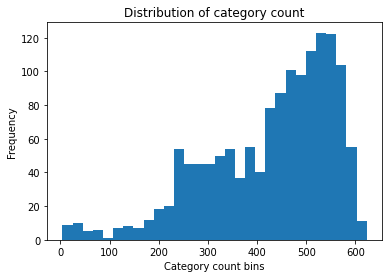

In [10]:
df.groupby('label')['term'].count().plot.hist(bins = 30)
plt.xlabel('Category count bins')
plt.title('Distribution of category count')
plt.show()

#### Finding:
 - more than 50% of categories have count skewed towards 460
 - some categories are rare, with much less than count than average. e.g., only 4 terms for category 587
 - Overall, no strong imbalances but for classes with extreme less counts underfitting may appear

#### 2.3 Review least and most frequent category

In [11]:
df_cat_count = df.groupby('label')['term'].count().sort_values(ascending = True).to_frame().reset_index(drop = False)

In [12]:
cat_least_freq = df_cat_count['label'].iloc[0]
print('Least frequent category: ', cat_least_freq)
cat_most_freq = df_cat_count['label'].iloc[-1]
print('Most frequent category: ', cat_most_freq)

Least frequent category:  587
Most frequent category:  54


In [13]:
df[ df['label'] == cat_least_freq ].sample(frac = 1)

,term,label
333393,innovation in financial services,587
373542,m commerce uk,587
143201,fintech big data,587
124007,client onboarding investment banking,587


In [14]:
df[ df['label'] == cat_most_freq ].sample(5)

,term,label
379083,bmw x3 2.0 d remap,54
317648,insignia vxr tuning,54
440109,tuning key,54
330489,volvo v70 d5 remap,54
447018,seat tuning,54


#### Review a random label

In [15]:
df[ df['label'] == 541 ].sort_values(by = 'term').tail(5)

,term,label
424920,レンタル wifi,541
6820,ロンドン wifi レンタル,541
494786,一時 帰国 wifi,541
254579,国内 wifi レンタル,541
453713,羽田 空港 wifi レンタル,541


#### Findings:
- frequent tokens appears in each category. e.g., 'tuning' appears in 3 terms out of 5 randomly sampled terms for category 54.
- there are non-English words in a term - more follows below
- many abbreviations appear. e.g, 'sat' is the same as 'satelite' in 541

#### 2.4 Punctuation check

In [16]:
# punctuation = [':', ',',';','?','!', '#', '&', '*', '.', '^', '@', '~', '/', '+', '-', '(', ')', '[', ']', '{', '}', '<', '>', '|', '\']
punctuation_list = list(string.punctuation)

In [17]:
def check_punctuation(df_in, var, punctuation):
  """
  This is to check if there is any punctuation in terms
  """
  punctuation_found = set()
  for punct in punctuation:
      for term in df_in[var]:
          if punct in term:
              punctuation_found.add(punct)
#                 punctuation.remove(punct)
#                 break
  return punctuation_found

In [18]:
punctuation_found = check_punctuation(df, 'term', punctuation_list)

In [19]:
punctuation_found

{'#', '&', "'", '*', '+', '.', '_'}

#### Findings:
- puncutation found include: ,'&+*#
- except ., remove the rest punctuation

In [20]:
def remove_punctuation(term, symbols):
    """
    This is to remove punctuation found above
    """
    for punct in symbols:
        term = term.replace(punct, '')
    return term

In [21]:
PUNCTUATION_REMOVAL = [punct for punct in punctuation_list if punct != '.']
df['term'] = [remove_punctuation(term, PUNCTUATION_REMOVAL)  for term in df['term']]

In [22]:
check_punctuation(df, 'term', punctuation_list)

{'.'}

#### 2.5 NonEnglish check

In [23]:
def check_non_english_word(df_in):
    """
    This is to check if there is any Non-English words in terms
    """
    pattern=re.compile(r'[^\x00-\x7f]')
    cols=['label', 'term']
    term_non_english_df = pd.DataFrame(columns=cols)
    for index, row in df_in.iterrows():
        term = row['term']
        label = row['label']
        temp_term = []
        if pattern.search(term) is not None:
            temp_term.append(label)
            temp_term.append(term)
            term_non_english_df.loc[len(term_non_english_df)] = temp_term
            # term_non_english_df = term_non_english_df.append(pd.DataFrame(temp_term), ignore_index=True)
    return term_non_english_df
  

In [24]:
term_non_eng = check_non_english_word(df)

In [25]:
term_non_eng.head()

,label,term
0,1265,海运 回国
1,201,thermomètre
2,795,انگشتر فیروزه
3,1112,英国 转学
4,124,欧美 家 机票


In [26]:
term_non_eng.groupby('label')['term'].count().sort_values(ascending=False).describe()

count    235.000000
mean       2.927660
std        5.931147
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       62.000000
Name: term, dtype: float64

Text(0.5, 1.0, 'Terms with Non-English chars percentage')

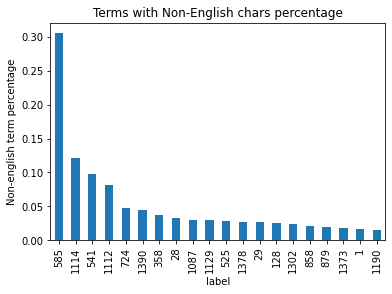

In [27]:
(term_non_eng.groupby('label')['term'].count() / df.groupby('label')['term'].count() ).sort_values(ascending=False).head(20).plot.bar()
plt.ylabel('Non-english term percentage')
plt.xlabel('label')
plt.title('Terms with Non-English chars percentage')

#### Findings:
- There are 4 categories with more than 5% of terms with Non-english words
- In total, 235 categories contain Non-English words

#### Methods:
- No further processing as tf-idf vectorizer applies to Non-english words
- Any English embedding work needs to consider imputation

#### 2.6 Stopwords check and remvoal

In [28]:
#resource: https://gist.github.com/sebleier/554280
STOPWORD_CUST_LIST = ['yeah','ah','uh','um','oh','all', 'me', 'my', 'myself', 'we', 'our', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'a', 'an', 'the', 'and', 'but', 'because', 'as', 'until', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'same', 'so', 'than', 's', 't']

In [29]:
def remove_stopwords(term, stopwords_list='customized', **kwargs):
    """
    This is to remove stop words, using customized stopwords list
    """
    text_tokens = word_tokenize(term)
    if stopwords_list=='spacy':
        tokens_without_sw = [word for word in text_tokens if not word in STOP_WORDS]
    
    elif stopwords_list=='nltk':
        tokens_without_sw = [word for word in text_tokens if not word in stopwords_nltk]
    
    elif stopwords_list=='customized':
        cust_stopwords=kwargs['cust_stopword']
        tokens_without_sw = [word for word in text_tokens if not word in cust_stopwords]
    
    raw_txt = " ".join(tokens_without_sw)

    return raw_txt

In [30]:
df['term_no_sw'] = [remove_stopwords(term, stopwords_list='customized', cust_stopword=STOPWORD_CUST_LIST) for term in df['term']]

In [31]:
df[ df['term'] != df['term_no_sw']].head(5)

,term,label,term_no_sw
4,used generators for sale uk,213,used generators sale uk
10,grey kettle and toaster,1350,grey kettle toaster
12,sightseeing in barcelona,248,sightseeing barcelona
14,map of cornwall uk,823,map cornwall uk
15,damp from chimney,343,damp chimney


In [32]:
df.head()

,term,label,term_no_sw
0,yew hedge,1221,yew hedge
1,fire detection shop,19,fire detection shop
2,cheap couch roll,398,cheap couch roll
3,extra watermelon gum,1108,extra watermelon gum
4,used generators for sale uk,213,used generators sale uk
